In [10]:
# install / upgrade necessary packages
# !pip install easydict
# !pip install numpy
# !pip install numpy --upgrade # upgrade numpy to at least 1.19
# !pip install torch --upgrade # upgrade pytorch to 1.5.1

In [11]:
from easydict import EasyDict
args = EasyDict()

args.epochs=11
args.dropout=0.0
args.lr=5e-5
args.gamma_exp=1000
args.hidden=800
args.ratio=1
args.dis_lambda=1.0
args.lambda_m=0.0
args.wgan='wgan'
args.clamp_lower=-0.15
args.clamp_upper=0.15
args.batch_size=100
args.num_train=100
args.loss='default'
args.evaluate=False
args.checkpoint='none'
args.save_head='tmp'
args.save_interval=20
args.log_interval=20
args.log_file='tmp_mlp'
args.seed=2 #2
args.cuda=False
args.device="cpu"

In [12]:
from __future__ import print_function
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable
from utils import plain_log
from utils import write_pickle,read_pickle
from utils import masked_cross_entropy
from utils import gaussian_loss
from torch.utils import data
from data_loader import toydata
import pandas as pd

label_noise_std = 0.50
use_label_noise = False
use_inverse_weighted = True
discr_thres = 999.999
normalize = True
train_discr_step_tot = 2
train_discr_step_extra = 0
slow_lrD_decay = 1
norm = 8
fname_save = 'pred_tmp.pkl'
fname = '/Users/avin/Desktop/Intrusion Detection/Datasets/awid.pkl'
fname_test='/Users/avin/Desktop/Intrusion Detection/Datasets/awid.pkl'
data = read_pickle(fname_test)
true_class=data['label']
train_list = list(range(2))
mask_list = [1] + [0] 
test_list = list(range(2))
cm= False
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
random.seed(args.seed)
torch.manual_seed(int(args.seed))

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    toydata(fname, train_list, normalize, mask_list),
    shuffle=True,
    batch_size=args.batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(
    toydata(fname_test, test_list, normalize),
    batch_size=args.batch_size, **kwargs)

print("Numpy version:", np.__version__)
print("Pytorch version:", torch.__version__)

Numpy version: 1.18.5
Pytorch version: 1.5.0


/Users/avin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/avin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [13]:
# load raw data and plot it for visualization only
#from plot import plot_dataset
#import matplotlib.pyplot as plt
#data_pkl = read_pickle(f'./awid.pkl')
#plot_dataset(data_pkl)
#plt.show()

In [14]:
# Encoder: domain as input to generate feature, and then concatenate, deep dynamic layers
class DomainEnc(nn.Module):
    def __init__(self):
        super(DomainEnc, self).__init__()
        self.hidden = args.hidden
        self.ratio = float(args.ratio)
        self.dropout = args.dropout

        self.fc1 = nn.Linear(153, self.hidden)
        self.drop1 = nn.Dropout(self.dropout)

        self.fc2 = nn.Linear(self.hidden + int(self.hidden // self.ratio), self.hidden + int(self.hidden // self.ratio))
        self.drop2 = nn.Dropout(self.dropout)

        self.fc3 = nn.Linear(self.hidden + int(self.hidden // self.ratio), self.hidden + int(self.hidden // self.ratio))
        self.drop3 = nn.Dropout(self.dropout)

        self.fc4 = nn.Linear(self.hidden + int(self.hidden // self.ratio), self.hidden + int(self.hidden // self.ratio))
        self.drop4 = nn.Dropout(self.dropout)

        self.fc_final = nn.Linear(self.hidden + int(self.hidden // self.ratio), self.hidden)

        self.fc1_var = nn.Linear(1, int(self.hidden // self.ratio))
        self.fc2_var = nn.Linear(int(self.hidden // self.ratio), int(self.hidden // self.ratio))
        self.fc3_var = nn.Linear(int(self.hidden // self.ratio), int(self.hidden // self.ratio))
        self.drop1_var = nn.Dropout(self.dropout)
        self.drop2_var = nn.Dropout(self.dropout)
        self.drop3_var = nn.Dropout(self.dropout)

    def forward(self, x):
        x, domain = x
        domain = domain.unsqueeze(1) / norm

        # side branch for variable FC
        x_domain = F.relu(self.fc1_var(domain))
        x_domain = self.drop1_var(x_domain)

        # main branch
        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        # combine feature in the middle
        x = torch.cat((x, x_domain), dim=1)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = F.relu(self.fc3(x))
        x = self.drop3(x)

        x = F.relu(self.fc4(x))
        x = self.drop4(x)

        # continue main branch
        x = F.relu(self.fc_final(x))

        return x

In [15]:
# Predictor
class DomainPred(nn.Module):
    def __init__(self):
        super(DomainPred, self).__init__()
        self.hidden = args.hidden
        self.dropout = args.dropout

        self.drop0 = nn.Dropout(self.dropout)

        self.fc1 = nn.Linear(self.hidden, self.hidden)
        self.drop1 = nn.Dropout(self.dropout)


        self.fc_final = nn.Linear(self.hidden, 153)

    def forward(self, x):
        x, domain = x
        domain = domain.unsqueeze(1) / norm

        x = self.drop0(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = self.fc_final(x)
        
        return F.log_softmax(x, dim=1)

In [16]:
# Discriminator: with BN layers after each FC, dual output
class DomainDDisc(nn.Module):
    def __init__(self):
        super(DomainDDisc, self).__init__()
        self.hidden = args.hidden
        self.dropout = args.dropout

        self.drop2 = nn.Dropout(self.dropout)

        self.fc3_m = nn.Linear(self.hidden, self.hidden)
        self.bn3_m = nn.BatchNorm1d(self.hidden)
        self.drop3_m = nn.Dropout(self.dropout)

        self.fc3_s = nn.Linear(self.hidden, self.hidden)
        self.bn3_s = nn.BatchNorm1d(self.hidden)
        self.drop3_s = nn.Dropout(self.dropout)

        self.fc4_m = nn.Linear(self.hidden, self.hidden)
        self.bn4_m = nn.BatchNorm1d(self.hidden)
        self.drop4_m = nn.Dropout(self.dropout)

        self.fc4_s = nn.Linear(self.hidden, self.hidden)
        self.bn4_s = nn.BatchNorm1d(self.hidden)
        self.drop4_s = nn.Dropout(self.dropout)

        self.fc5_m = nn.Linear(self.hidden, self.hidden)
        self.bn5_m = nn.BatchNorm1d(self.hidden)
        self.drop5_m = nn.Dropout(self.dropout)

        self.fc5_s = nn.Linear(self.hidden, self.hidden)
        self.bn5_s = nn.BatchNorm1d(self.hidden)
        self.drop5_s = nn.Dropout(self.dropout)

        self.fc6_m = nn.Linear(self.hidden, self.hidden)
        self.bn6_m = nn.BatchNorm1d(self.hidden)
        self.drop6_m = nn.Dropout(self.dropout)

        self.fc6_s = nn.Linear(self.hidden, self.hidden)
        self.bn6_s = nn.BatchNorm1d(self.hidden)
        self.drop6_s = nn.Dropout(self.dropout)

        self.fc7_m = nn.Linear(self.hidden, self.hidden)
        self.bn7_m = nn.BatchNorm1d(self.hidden)
        self.drop7_m = nn.Dropout(self.dropout)

        self.fc7_s = nn.Linear(self.hidden, self.hidden)
        self.bn7_s = nn.BatchNorm1d(self.hidden)
        self.drop7_s = nn.Dropout(self.dropout)

        self.fc_final_m = nn.Linear(self.hidden, 1)
        self.fc_final_s = nn.Linear(self.hidden, 1)        

    def forward(self, x):
        x, domain = x
        domain = domain.unsqueeze(1) / norm

        x = self.drop2(x)

        x_m = F.relu(self.bn3_m(self.fc3_m(x)))
        x_m = self.drop3_m(x_m)

        x_s = F.relu(self.bn3_s(self.fc3_s(x)))
        x_s = self.drop3_s(x_s)

        x_m = F.relu(self.bn4_m(self.fc4_m(x_m)))
        x_m = self.drop4_m(x_m)

        x_s = F.relu(self.bn4_s(self.fc4_s(x_s)))
        x_s = self.drop4_s(x_s)

        x_m = F.relu(self.bn5_m(self.fc5_m(x_m)))
        x_m = self.drop5_m(x_m)

        x_s = F.relu(self.bn5_s(self.fc5_s(x_s)))
        x_s = self.drop5_s(x_s)

        x_m = F.relu(self.bn6_m(self.fc6_m(x_m)))
        x_m = self.drop6_m(x_m)

        x_s = F.relu(self.bn6_s(self.fc6_s(x_s)))
        x_s = self.drop6_s(x_s)

        x_m = F.relu(self.bn7_m(self.fc7_m(x_m)))
        x_m = self.drop7_m(x_m)

        x_s = F.relu(self.bn7_s(self.fc7_s(x_s)))
        x_s = self.drop7_s(x_s)

        x_m = self.fc_final_m(x_m)
        x_s = self.fc_final_s(x_s) # log sigma^2

        return (x_m, x_s)

In [17]:
# Create models
encoder = DomainEnc()
predictor = DomainPred()
discriminator = DomainDDisc()
models = [encoder, predictor, discriminator]
if args.cuda:
    for model in models:
        model.cuda()    

Train Epoch 1: avg_discr_loss = 0.05417, avg_pred_loss = 5497918566.400, avg_total_loss = 5497918566.400,
Test set: Average loss: 3384902462.12, Accuracy: 2359/3000 (78.63%), Precision: 0.83%, Recall: 0.79%, f1: 0.78%
Train Epoch 2: avg_discr_loss = -0.09936, avg_pred_loss = 2275094240.000, avg_total_loss = 2275094240.000,
Test set: Average loss: 2259282438.83, Accuracy: 2575/3000 (85.83%), Precision: 0.88%, Recall: 0.86%, f1: 0.86%
Train Epoch 3: avg_discr_loss = -0.20874, avg_pred_loss = 1523757864.533, avg_total_loss = 1523757864.533,
Test set: Average loss: 786645886.29, Accuracy: 2743/3000 (91.43%), Precision: 0.92%, Recall: 0.91%, f1: 0.91%
Train Epoch 4: avg_discr_loss = -0.31047, avg_pred_loss = 1135570520.267, avg_total_loss = 1135570520.267,
Test set: Average loss: 793660798.29, Accuracy: 2805/3000 (93.50%), Precision: 0.94%, Recall: 0.94%, f1: 0.93%
Train Epoch 5: avg_discr_loss = -0.40543, avg_pred_loss = 1310628496.000, avg_total_loss = 1310628496.000,
Test set: Average lo

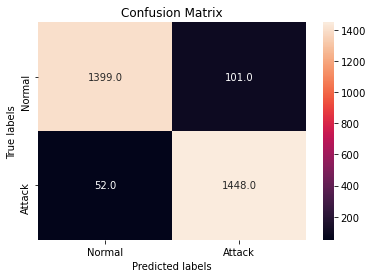

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

torch.autograd.set_detect_anomaly(True)

# Set up optimizer
opt_D = optim.Adam(discriminator.parameters(), lr = args.lr) # lr 
opt_non_D = optim.Adam(list(encoder.parameters()) + list(predictor.parameters()), lr = args.lr) # lr 
lr_scheduler_D = lr_scheduler.ExponentialLR(optimizer=opt_D, gamma=0.5 ** (1/(args.gamma_exp*(train_discr_step_extra+1)) * slow_lrD_decay))
lr_scheduler_non_D = lr_scheduler.ExponentialLR(optimizer=opt_non_D, gamma=0.5 ** (1/args.gamma_exp))

ind = list(range(args.batch_size))
ind_test = list(range(1000))
bce = nn.BCELoss()
mse = nn.MSELoss()

# Training loop
def train(epoch):
    for model in models:
        model.train()
    sum_discr_loss = 0
    sum_total_loss = 0
    sum_pred_loss = 0
    for batch_idx, data_tuple in enumerate(train_loader):
        if args.cuda:
            data_tuple = tuple(ele.cuda() for ele in data_tuple)
        if normalize:
            data_raw, target, domain, data, mask = data_tuple
        else:
            data, target, domain, mask = data_tuple

        # FF encoder and predictor
        encoding = encoder((data, domain))
        prediction = predictor((encoding, domain))

        if use_label_noise:
            noise = (torch.randn(domain.size()).cuda() * label_noise_std).unsqueeze(1)

        # train discriminator
        train_discr_step = 0
        while args.dis_lambda > 0.0:
            train_discr_step += 1
            discr_pred_m, discr_pred_s = discriminator((encoding, domain))
            discr_loss = gaussian_loss(discr_pred_m, discr_pred_s, domain.unsqueeze(1) / norm, np.mean(train_list) / norm, norm)
            for model in models:
                model.zero_grad()
            discr_loss.backward(retain_graph=True)
            opt_D.step()

            # handle extra steps to train the discr's variance branch
            if train_discr_step_extra > 0:
                cur_extra_step = 0
                while True:
                    discr_pred_m, discr_pred_s = discriminator((encoding, domain))
                    discr_loss = gaussian_loss(discr_pred_m.detach(), discr_pred_s, domain.unsqueeze(1) / norm)
                    for model in models:
                        model.zero_grad()
                    discr_loss.backward(retain_graph=True)
                    opt_D.step()
                    cur_extra_step += 1
                    if cur_extra_step > train_discr_step_extra:
                        break

            if discr_loss.item() < 1.1 * discr_thres and train_discr_step >= train_discr_step_tot:
                sum_discr_loss += discr_loss.item()
                break

        # handle wgan
        if args.wgan == 'wgan':
            for p in discriminator.parameters():
                p.data.clamp_(args.clamp_lower, args.clamp_upper)

        # train encoder and predictor
        pred_loss = masked_cross_entropy(prediction, target, mask)
        discr_pred_m, discr_pred_s = discriminator((encoding, domain))
        ent_loss = 0

        discr_loss = gaussian_loss(discr_pred_m, discr_pred_s, domain.unsqueeze(1) / norm)
        total_loss = pred_loss - discr_loss * args.dis_lambda

        for model in models:
            model.zero_grad()
        total_loss.backward()
        opt_non_D.step()
        sum_pred_loss += pred_loss.item()
        sum_total_loss += total_loss.item()

    lr_scheduler_D.step()
    lr_scheduler_non_D.step()

    avg_discr_loss = sum_discr_loss / len(train_loader.dataset) * args.batch_size
    avg_pred_loss = sum_pred_loss / len(train_loader.dataset) * args.batch_size
    avg_total_loss = sum_total_loss / len(train_loader.dataset) * args.batch_size
    log_txt = 'Train Epoch {}: avg_discr_loss = {:.5f}, avg_pred_loss = {:.3f}, avg_total_loss = {:.3f},'.format(epoch, avg_discr_loss, avg_pred_loss, avg_total_loss)
    print(log_txt)
    plain_log(args.log_file,log_txt+'\n')
    if epoch % args.save_interval == 0 and epoch != 0:
        torch.save(encoder, '%s.model_enc' % args.save_head)
        torch.save(predictor, '%s.model_pred' % args.save_head)
        torch.save(discriminator, '%s.model_discr' % args.save_head)

# Testing loop
def test():
    for model in models:
        model.eval()
    test_loss = 0
    rmse_loss = 0
    correct = 0
    l_data = []
    l_label = []
    l_gt = []
    l_encoding = []
    l_domain = []
    l_prob = []
    #for data, target, domain in test_loader:
    for data_tuple in test_loader:
        if args.cuda:
            data_tuple = tuple(ele.cuda() for ele in data_tuple)
        if normalize:
            data_raw, target, domain, data = data_tuple
        else:
            data, target, domain = data_tuple
            data_raw = data
        encoding = encoder((data, domain))
        prediction = predictor((encoding, domain))
        test_loss += F.nll_loss(prediction, target, reduction='sum').item() # sum up batch loss
        pred = prediction.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).cpu().sum()
##
        l_data.append(data_raw.cpu().numpy())
        l_label.append(pred.cpu().numpy())
        l_gt.append(target.cpu().numpy())
        l_encoding.append(encoding.data.cpu().numpy())
        l_domain.append(domain.data.cpu().numpy())
        l_prob.append(prediction.data.cpu().numpy())

    data_all = np.concatenate(l_data, axis=0)
    label_all = np.concatenate(l_label, axis=0)
    gt_all = np.concatenate(l_gt, axis=0)
    encoding_all = np.concatenate(l_encoding, axis=0)
    domain_all = np.concatenate(l_domain, axis=0)
    prob_all = np.concatenate(l_prob, axis=0)
    d_pkl = dict()
    d_pkl['data'] = data_all
    d_pkl['label'] = label_all[:, 0]
    d_pkl['gt'] = gt_all
    d_pkl['encoding'] = encoding_all
    d_pkl['domain'] = domain_all
    d_pkl['prob'] = prob_all
    write_pickle(d_pkl, fname_save)
    
    p=np.asarray(label_all)
    x=pd.DataFrame(p.flatten(),columns = ['col1'])
    predicted_class=x['col1'].to_numpy()

    pre= precision_score(true_class, predicted_class, average= 'macro')
    recall= recall_score(true_class, predicted_class, average= 'macro')
    f1= f1_score(true_class, predicted_class, average= 'macro')
    test_loss /= len(test_loader.dataset)
    log_txt = 'Test set: Average loss: {:.2f}, Accuracy: {}/{} ({:.2f}%), Precision: {:.2f}%, Recall: {:.2f}%, f1: {:.2f}%'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), pre, recall, f1)
    print(log_txt)
    if(cm==True):
        conf=confusion_matrix(true_class,predicted_class)
        ax= plt.subplot()
        sns.heatmap(conf, annot=True, ax = ax, fmt=".1f")
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels([ 'Normal', 'Attack']); ax.yaxis.set_ticklabels(['Normal', 'Attack']);
        plt.show()

    plain_log(args.log_file,log_txt+'\n')

if args.checkpoint != 'none':
    encoder = torch.load(args.checkpoint + '_enc')
    predictor = torch.load(args.checkpoint + '_pred')
    discriminator = torch.load(args.checkpoint + '_discr')
    opt_D = optim.Adam(discriminator.parameters(), lr = args.lr) # lr 
    opt_non_D = optim.Adam(list(encoder.parameters()) + list(predictor.parameters()), lr = args.lr) # lr 
    lr_scheduler_D = lr_scheduler.ExponentialLR(optimizer=opt_D, gamma=0.5 ** (1/(args.gamma_exp*(train_discr_step_extra+1)) * slow_lrD_decay))
    lr_scheduler_non_D = lr_scheduler.ExponentialLR(optimizer=opt_non_D, gamma=0.5 ** (1/args.gamma_exp))
    models = [encoder, predictor, discriminator]
    for model in models:
        for key, module in model._modules.items():
            print('key', key)
            print('module', module)

if not args.evaluate:
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch % 1 == 0:
            test()
cm=True
test()